In [1]:
import pandas as pd
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

# Overal Data SetManipulations

How we used this first notebook that we iterated/cleaned on the csvs here, and then saved it to a github repo. From there we could independently pull/push our cleaned and merged datasets

In [2]:
meta = pd.read_csv('./the-movies-dataset-clean/movies_metadata.csv')

/Users/nickparker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Column Math

In [3]:
### Adding profit and use of Budget Columns
meta['profit'] = meta['revenue'] - pd.to_numeric(meta['budget'],errors='coerce')
meta['useOfBudget'] = meta['revenue'] / (pd.to_numeric(meta['budget'],errors='coerce') + 000.1)

# Splitting Columns with multiple values

In [4]:
#This function takes in a column which contains a dictionary
#It splits it by the elements of the dict into n new columsn columns
#example: 
#genre[0]=[{'name':'mystery'},{'name':'thriller'}] --> genre_1[0] = 'mystery', genre_2 = 'thriller' 
def splitDict(df, colToSplit, n):   
    for i in range(n):
        newCol = []
        for rowNum in range(df.shape[0]):
            try: 
                newCol.append(ast.literal_eval(df[colToSplit][rowNum])[i]['name'])
            except:
                newCol.append('nan')
        newColName = colToSplit + '_'+ str(i+1)
        df[newColName] = newCol
    df = df.drop(colToSplit,axis = 1)
    return df

In [5]:
meta = splitDict(meta, 'production_companies', 6)
meta = splitDict(meta, 'genres', 3)
meta.columns

Index(['adult', 'belongs_to_collection', 'budget', 'homepage', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_countries', 'release_date', 'revenue',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'profit', 'useOfBudget',
       'production_companies_1', 'production_companies_2',
       'production_companies_3', 'production_companies_4',
       'production_companies_5', 'production_companies_6', 'genres_1',
       'genres_2', 'genres_3'],
      dtype='object')

## Merging

In [6]:
#Here we add two more datasets
#ratings, contains 26 millions reviews
ratings = pd.read_csv('./the-movies-dataset-clean/ratings.csv')
#links is a helpful dataset with movie id's and imdb id's
links = pd.read_csv('./the-movies-dataset-clean/links.csv')

#First we aggregate ratings by movie
ratings = ratings.groupby('movieId').agg({'rating':['mean','count']}).reset_index() #gets average rating
ratings.columns = ['movieId','rating','rateCounts']
#Then we merge the ratings onto links
linkAvgRating = pd.merge(links,ratings,on='movieId',how='left')

#Then we standardized the merge column (imdbID) and merge it together
meta['imdbId'] = pd.to_numeric(meta['imdb_id'].str[2:])
meta = pd.merge(meta,linkAvgRating,on='imdbId',how='left')

## Making Flops dataframe

In [7]:
#Since revenue and budget are such important columns to us,
#We remove columns with missing values (0 is an illogical budget)
flop = meta.loc[((meta['revenue'] > 0) & pd.to_numeric(meta['budget'],errors='coerce' != 0))]
flop['flop'] = 0
flop.loc[(flop['profit'] < 0),'flop'] = 1

/Users/nickparker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nickparker/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Making the df longer based on genre

In [8]:
#Here we do the equivelent of melt by making the df long to wide  for genre
long_df_genre = pd.wide_to_long(flop.reset_index(), 
                          i=['index'], 
                          j='genreNo',
                          stubnames='genres',
                          sep="_")
long_df_genre.reset_index(inplace=True)

## Making the df longer based on prod company

In [9]:
#We do the same for production company
long_df_prod = pd.wide_to_long(flop.reset_index(), 
                          i=['index'], 
                          j='companyNo',
                          stubnames='production_companies',
                          sep="_")
long_df_prod.shape

(32286, 34)

In [10]:
long_df_prod.columns

Index(['release_date', 'runtime', 'popularity', 'tmdbId', 'profit', 'genres_3',
       'genres_2', 'poster_path', 'homepage', 'imdb_id',
       'belongs_to_collection', 'production_countries', 'adult',
       'original_title', 'rating', 'rateCounts', 'movieId', 'vote_average',
       'imdbId', 'flop', 'revenue', 'tagline', 'video', 'vote_count',
       'useOfBudget', 'spoken_languages', 'title', 'status', 'overview',
       'original_language', 'id', 'budget', 'genres_1',
       'production_companies'],
      dtype='object')

In [11]:
#checking it split correctly
long_df_prod.reset_index(inplace=True)

display = long_df_prod[['title','id','companyNo','production_companies']]

display.sort_values('id').head(6)

title   id  companyNo  \
17079  Lock, Stock and Two Smoking Barrels  100          4   
22460  Lock, Stock and Two Smoking Barrels  100          5   
11698  Lock, Stock and Two Smoking Barrels  100          3   
27841  Lock, Stock and Two Smoking Barrels  100          6   
6317   Lock, Stock and Two Smoking Barrels  100          2   
936    Lock, Stock and Two Smoking Barrels  100          1   

      production_companies  
17079                  nan  
22460                  nan  
11698                  nan  
27841                  nan  
6317                   nan  
936                    nan

# Export

#### When we are done with the data manipulation, we saved it as csv in our Github and were able to work from there

In [12]:
#export_csv = meta.to_csv (r'movie_dataset_edited/meta.csv', header=True)
#Don't forget to add '.csv' at the end of the path

In [13]:
#export_csv = flop.to_csv (r'movie_dataset_edited/flopDataSet.csv', header=True)


In [14]:
#export_csv = long_df_genre.to_csv (r'movie_dataset_edited/flopTripleByGenre.csv', header=True)


In [15]:
%load_ext rpy2.ipython

In [16]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [17]:
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [18]:
%R library(jpeg)

array(['jpeg', 'scales', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

# Figure Creation and Associtated Data Manipulations

# Figure 1 - Intro to Flops

In [19]:
flopfav = pd.read_csv('./movie_dataset_edited/flopDataSet.csv')

#Some of our favorite films
favdf = flopfav.iloc[[2185, 2534, 2962, 3883, 4125,2113, 2872]]
favdf = favdf[['title','revenue','budget','profit']]

#Labeling if the film was a flop or not
favdf['flopRank'] = '"flop"'
favdf.loc[(favdf.revenue/favdf.budget > 1),'flopRank'] = '"profitable"'
favdf['revenue'] = favdf['revenue']/1000000
favdf['budget'] = favdf['budget']/1000000
%R -i favdf
favdf

title     revenue  budget      profit      flopRank
2185         Big Fish  122.919055    70.0  52919055.0  "profitable"
2534     Coach Carter   76.669806    30.0  46669806.0  "profitable"
2962         Sunshine   32.017803    50.0 -17982197.0        "flop"
3883        Moneyball  110.206216    50.0  60206216.0  "profitable"
4125      Cloud Atlas  130.482868   102.0  28482868.0  "profitable"
2113   School of Rock  131.282949    35.0  96282949.0  "profitable"
2872  Children of Men   69.959751    76.0  -6040249.0        "flop"

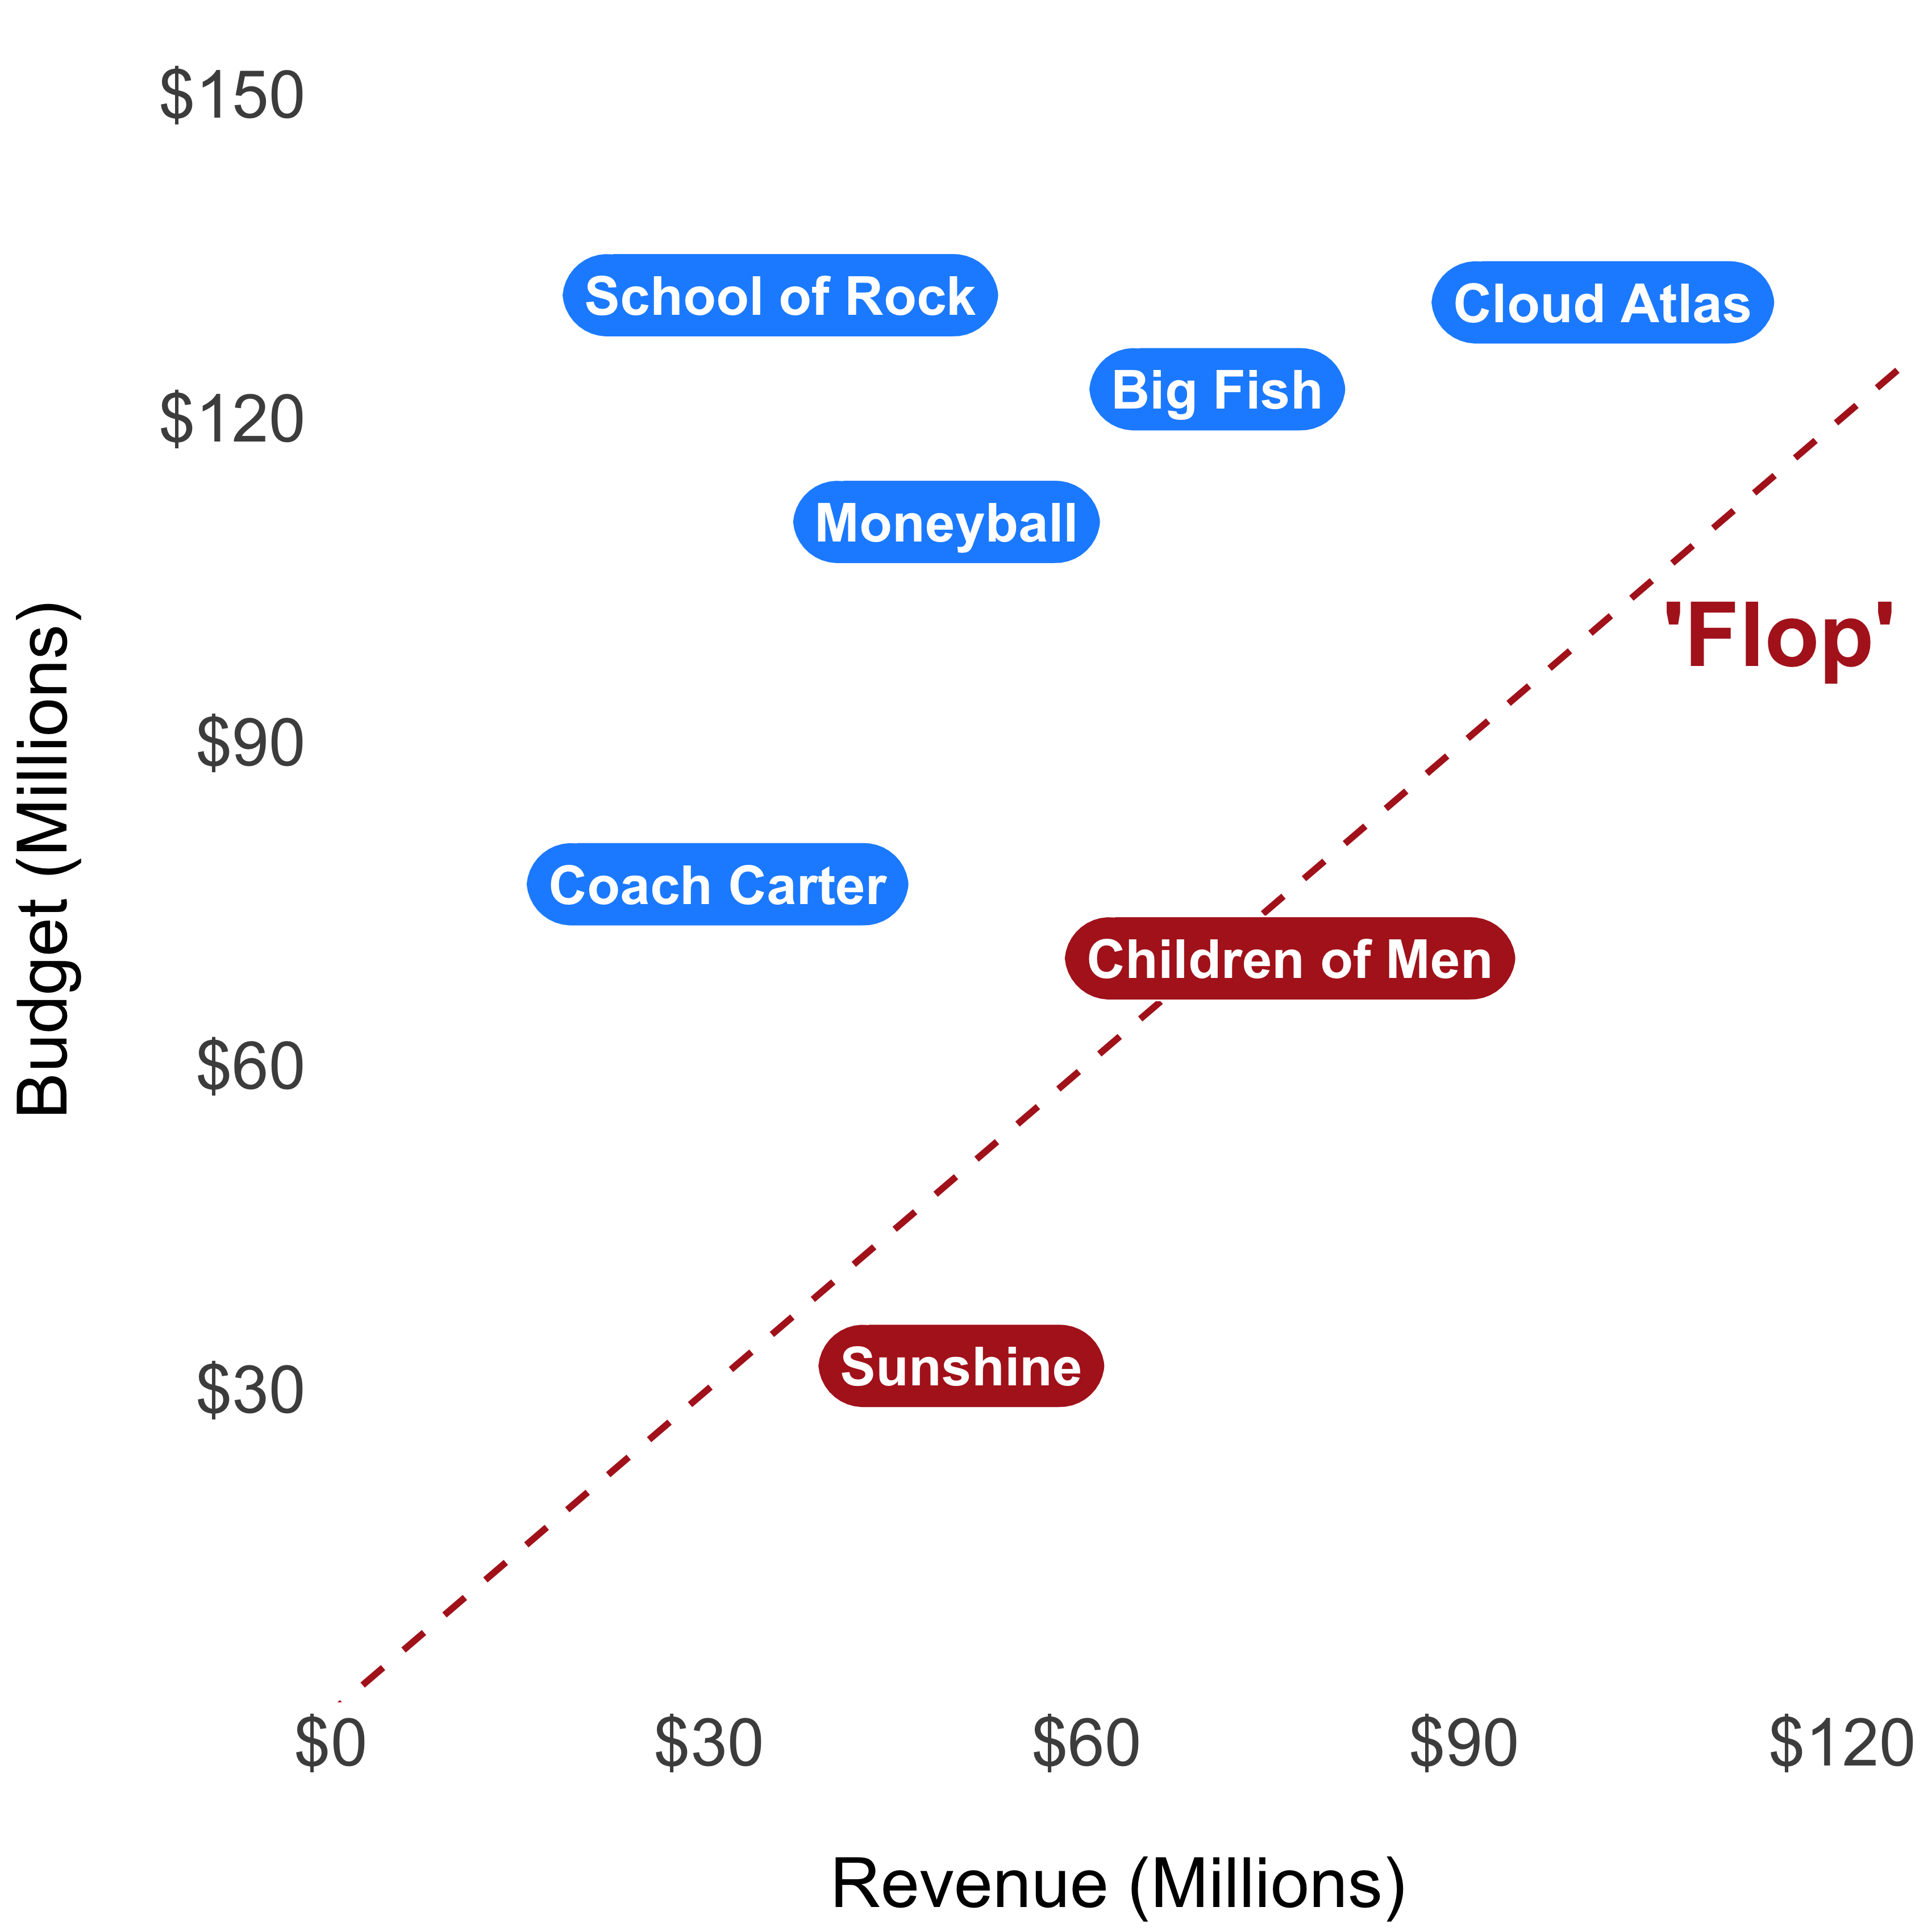

In [20]:
%%R -w 8.5 -h 8.5 --units in -r 400
(
ggplot()
+ geom_abline(slope = 1, linetype = 'dashed',size = 1, color = 'firebrick')
+ geom_label(aes(x= budget, y = revenue, label = title, fill = flopRank)
             ,color = 'white',data = favdf, position = 'jitter'
             , size = 6,fontface = 'bold'
             ,label.padding=unit(0.5,"lines")
            ,label.r=unit(1,"lines"))
+ scale_x_continuous(limits = c(5, 120), breaks = seq(0, 120, by = 30),label = dollar)
+ scale_y_continuous(limits = c(8, 150), breaks = seq(0, 150, by = 30),label = dollar)
+ annotate("text", x = 115, y = 100, label = "'Flop'",fontface = 'bold', color='firebrick',size = 10)

    
+ xlab('\nRevenue (Millions)')
+ ylab('Budget (Millions)\n')
+ scale_fill_manual(values = c('firebrick', 'dodgerblue'))

+ theme(
        axis.text.y=element_text(size = 21)
        , axis.text.x=element_text(size = 21)
        , axis.title.y=element_text(size = 22)
        , axis.title.x=element_text(size = 22)
        , panel.background=element_blank()
        , panel.grid.major=element_blank()
        , panel.grid.minor=element_blank()
        , axis.ticks = element_blank()
       )
+ guides(fill = F)
    )
#ggsave(filename="./finished_figures/fig1.png", width=8.5, height=8.5, units='in')

# Figure 2 - Top 10 Flops

In [21]:
flopdf = pd.read_csv('./flopDataSet.csv')

#Removing Foreign films
flopdf = flopdf.loc[((flopdf.genre1 != 'Foreign')&(flopdf.genre2 != 'Foreign')&(flopdf.genre3 != 'Foreign'))]
flopdf = flopdf.drop(713,axis=0)

#Using this stat for our Figure
percentFlop = flopdf.loc[(flopdf['flop']==1)].shape[0] / flopdf.shape[0]
print(percentFlop)
biggestFlops = flopdf.nsmallest(10,'profit')[['title','release_date','profit','rating','poster_path']]
biggestFlops['losses'] = biggestFlops['profit']/1000000 * -1
biggestFlops['profit'] = biggestFlops['profit']/1000000

#Abridging some of the titles to standardize the axis
biggestFlops['title'][5357] = 'Valerian'
biggestFlops['title'][1834] = 'Pluto Nash'

0.29800335883560364


/Users/nickparker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/nickparker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [22]:
%R img <- jpeg::readJPEG("./loneranger1.jpg")
%R -i biggestFlops

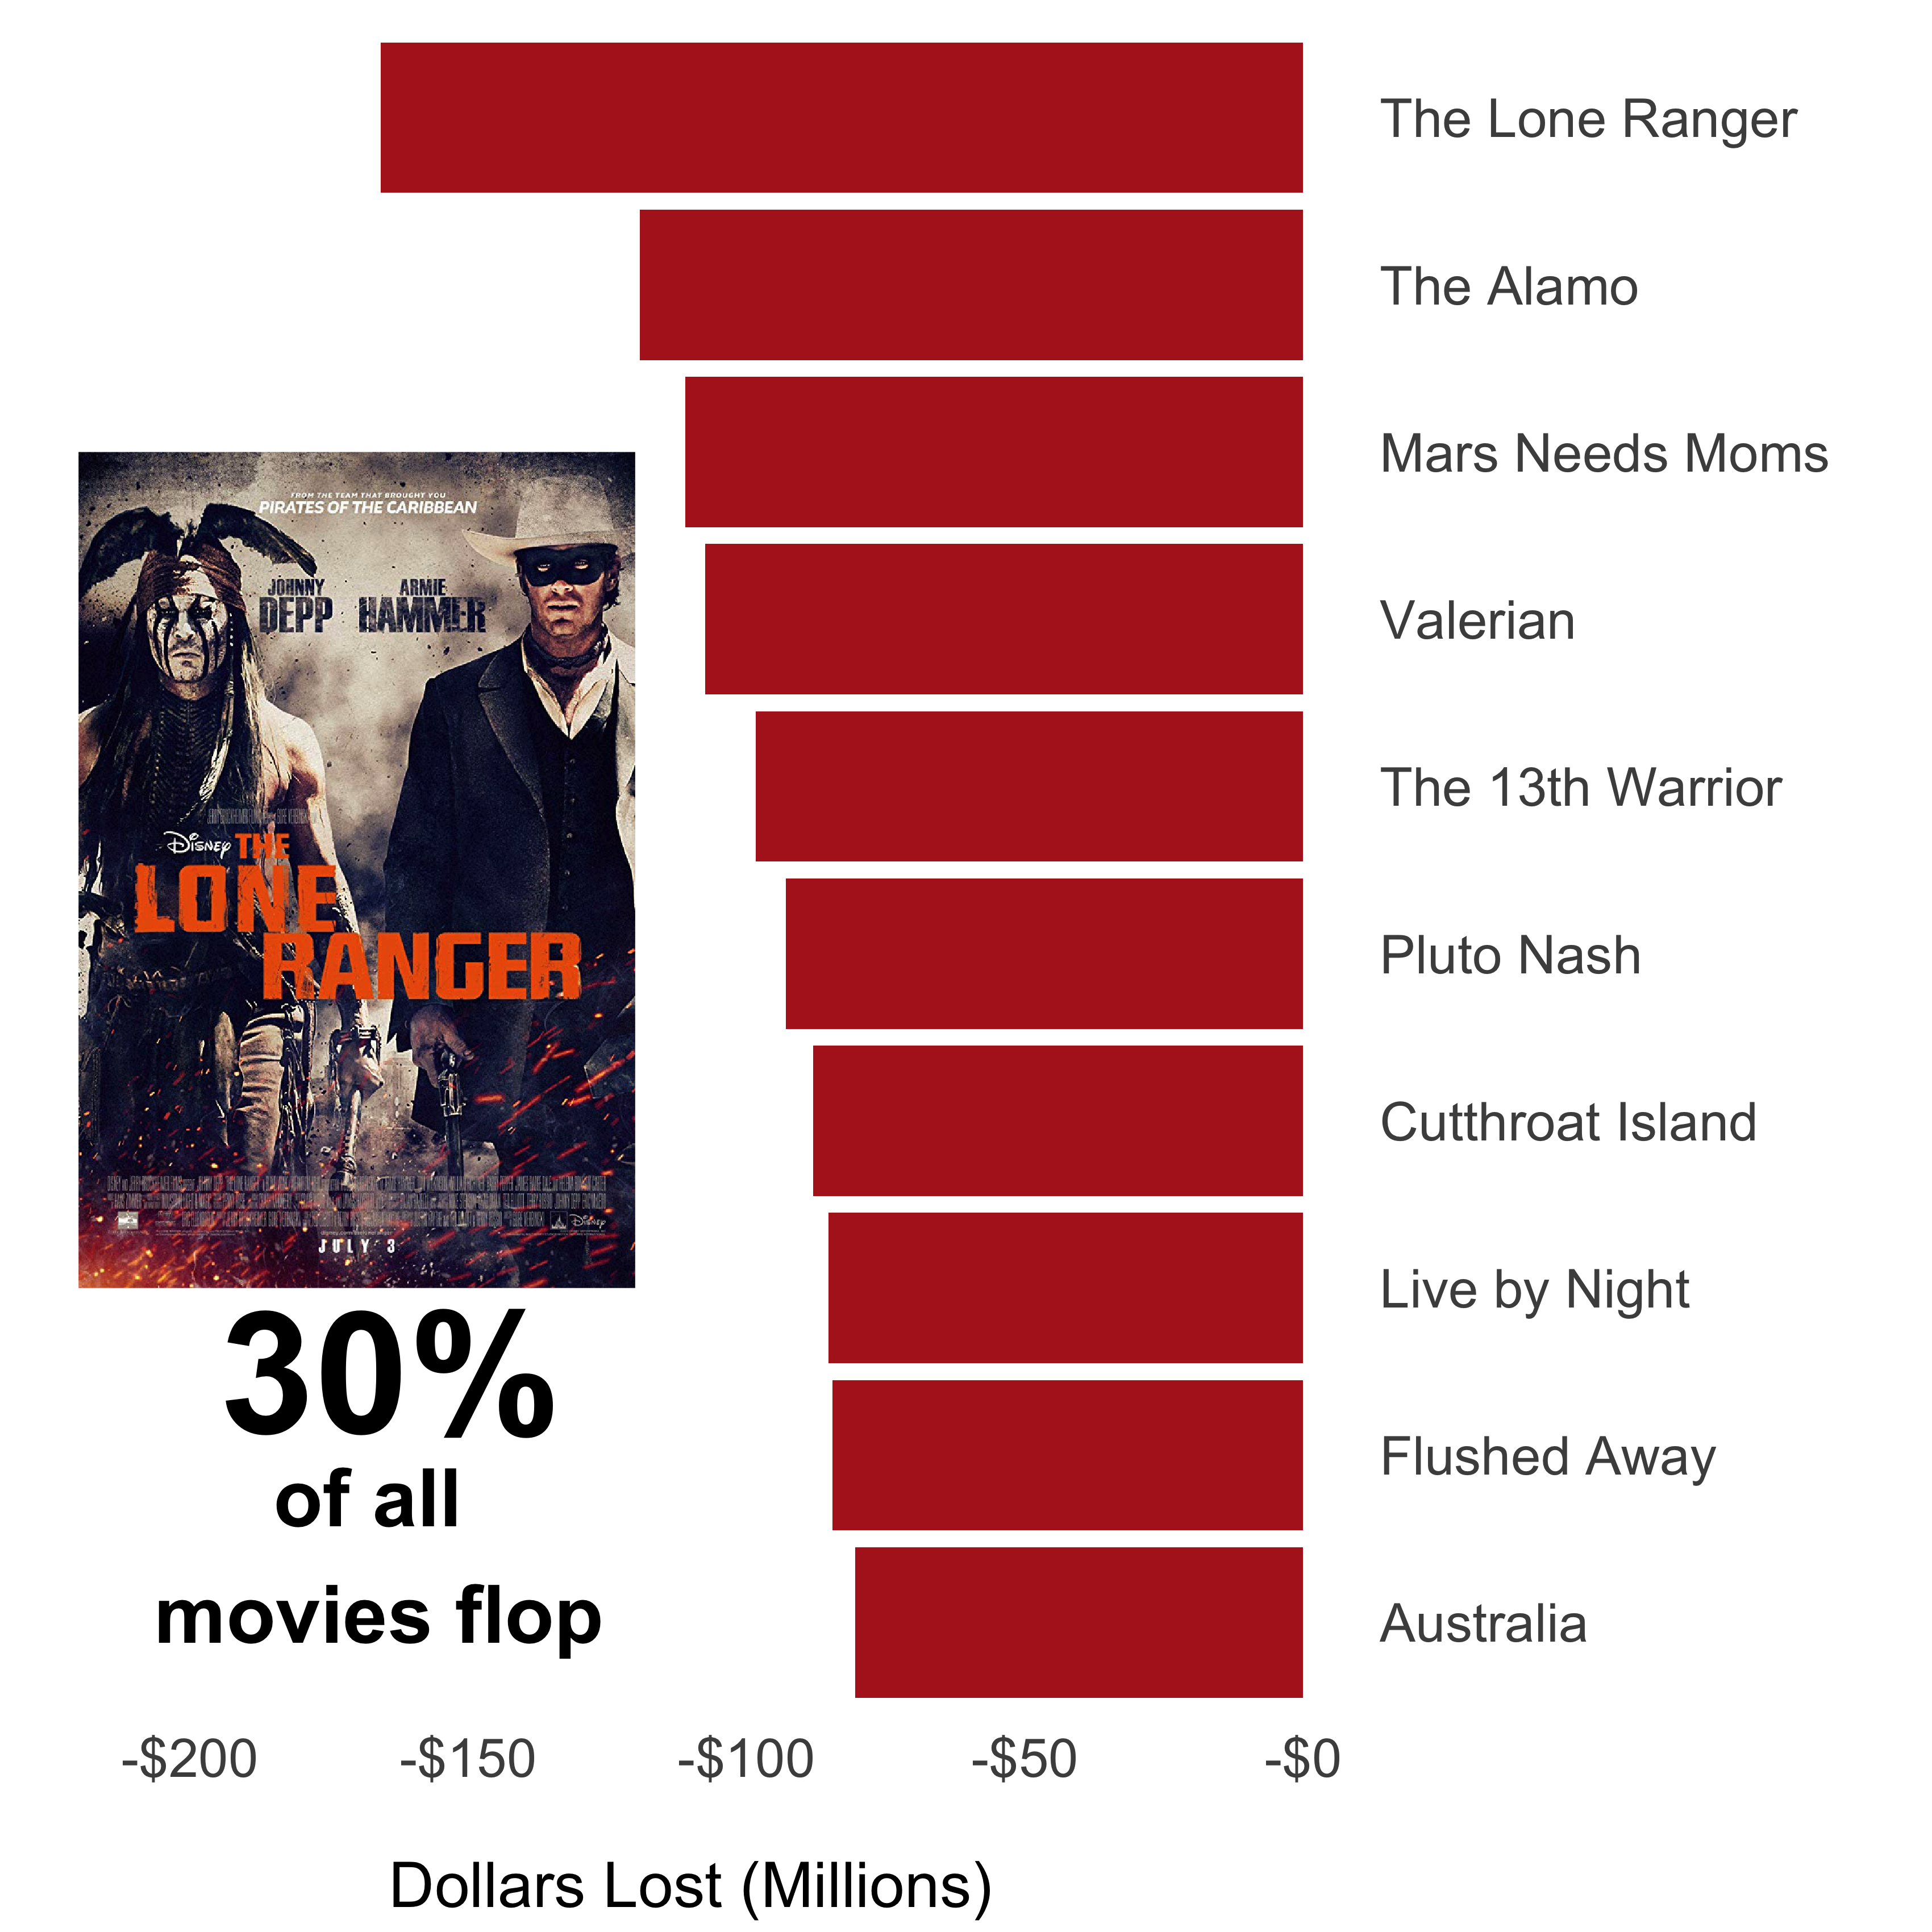

In [23]:
%%R -w 8.5 -h 8.5 --units in -r 400
(
ggplot()
+ geom_bar(aes(x= reorder(title,+losses), y = profit), fill = 'firebrick' ,data = biggestFlops, stat = 'identity')
+ scale_y_continuous(limits = c(-220, 0), breaks = seq(-200, 0, by = 50),label = function(x) paste0("-$",abs(x)))#labels = c(200,150,)
+ scale_x_discrete(position="top") # Which Side do I want the axis on?
+ coord_flip()
+ xlab('')
+ ylab('\nDollars Lost (Millions)')
+ annotate("text", x = 2.5, y = -164, label = "30%",fontface = 'bold', size = 19)
+ annotate("text", x = 1.4, y = -166, label = "of all \nmovies flop",fontface = 'bold', size = 9)

+theme_minimal()

+ theme(
        axis.text.y=element_text(size = 17)
        , axis.text.x=element_text(size = 17)
        , axis.title.y=element_text(size = 30)
        , axis.title.x=element_text(size = 20)
        , panel.background=element_blank()
        , panel.grid.major=element_blank()
        , panel.grid.minor=element_blank()
    )
+ annotation_raster(img, xmin = 3.0,xmax= 8,ymin = -220,ymax = -120)
)
#ggsave(filename="./finished_figures/fig2.png", width=8.5, height=8.5, units='in') 

# Figure 5: Intro to Months

In [24]:
dfFlop = pd.read_csv('./movie_dataset_edited/flopTripleByGenre.csv')

In [25]:
#Use a date time object to make a 
dfFlop['release_date'] = pd.to_datetime(dfFlop['release_date'], errors='coerce')
dfFlop['Month'] = dfFlop['release_date'].dt.month

In [26]:
#Finding worst month
worstMonth = dfFlop.groupby('Month').agg({'flop':['mean']}).reset_index()
worstMonth.columns = ['Release Month','Flop Rate']
worstMonth.sort_values('Flop Rate',ascending = False).head(4)

Release Month  Flop Rate
8              9   0.425361
9             10   0.349398
0              1   0.334311
1              2   0.326087

In [27]:
#We find out that September has the highest flop rate by a lot

In [28]:
#Making a dataframe with the films which came out in September
dfSept = dfFlop.loc[(dfFlop['Month']==9)]
flopRateOverall = dfFlop.groupby('genre').agg({'flop':['mean']}).reset_index()
flopRateSept = dfSept.groupby('genre').agg({'flop':['mean']}).reset_index()

flopRateOverall.columns = ['genre','FR']
flopRateSept.columns = ['genre','FR']

flopRateOverall['Time'] = 'All Months'
flopRateSept['Time'] = 'Sept'

#Dropping foreign films
flopRateOverall.drop(16)
flopRateSept.drop(16)
print('')

In [29]:
importdf = pd.concat([flopRateOverall,flopRateSept],ignore_index=True,axis = 0)

In [30]:
#Picking some values to make it less busy
importdf = importdf.iloc[[0, 20, 3, 23,6, 26,15,35,18,37,4,24]]

In [31]:
#Adding average values
avgFRoverall = ['all',dfFlop['flop'].mean(),'All Months']
avgFRsept = ['all',dfFlop.loc[(dfFlop['Month']==9)]['flop'].mean(),'Sept']
data = [avgFRoverall,avgFRsept]
alldf = pd.DataFrame(data, columns = ['genre','FR','Time'])

In [32]:
#Figure out the raise in rate froms September
#We will use this on our figure
print(alldf['FR'][1]-alldf['FR'][0])

0.12708945898758578


In [33]:
%R -i importdf
%R -i alldf

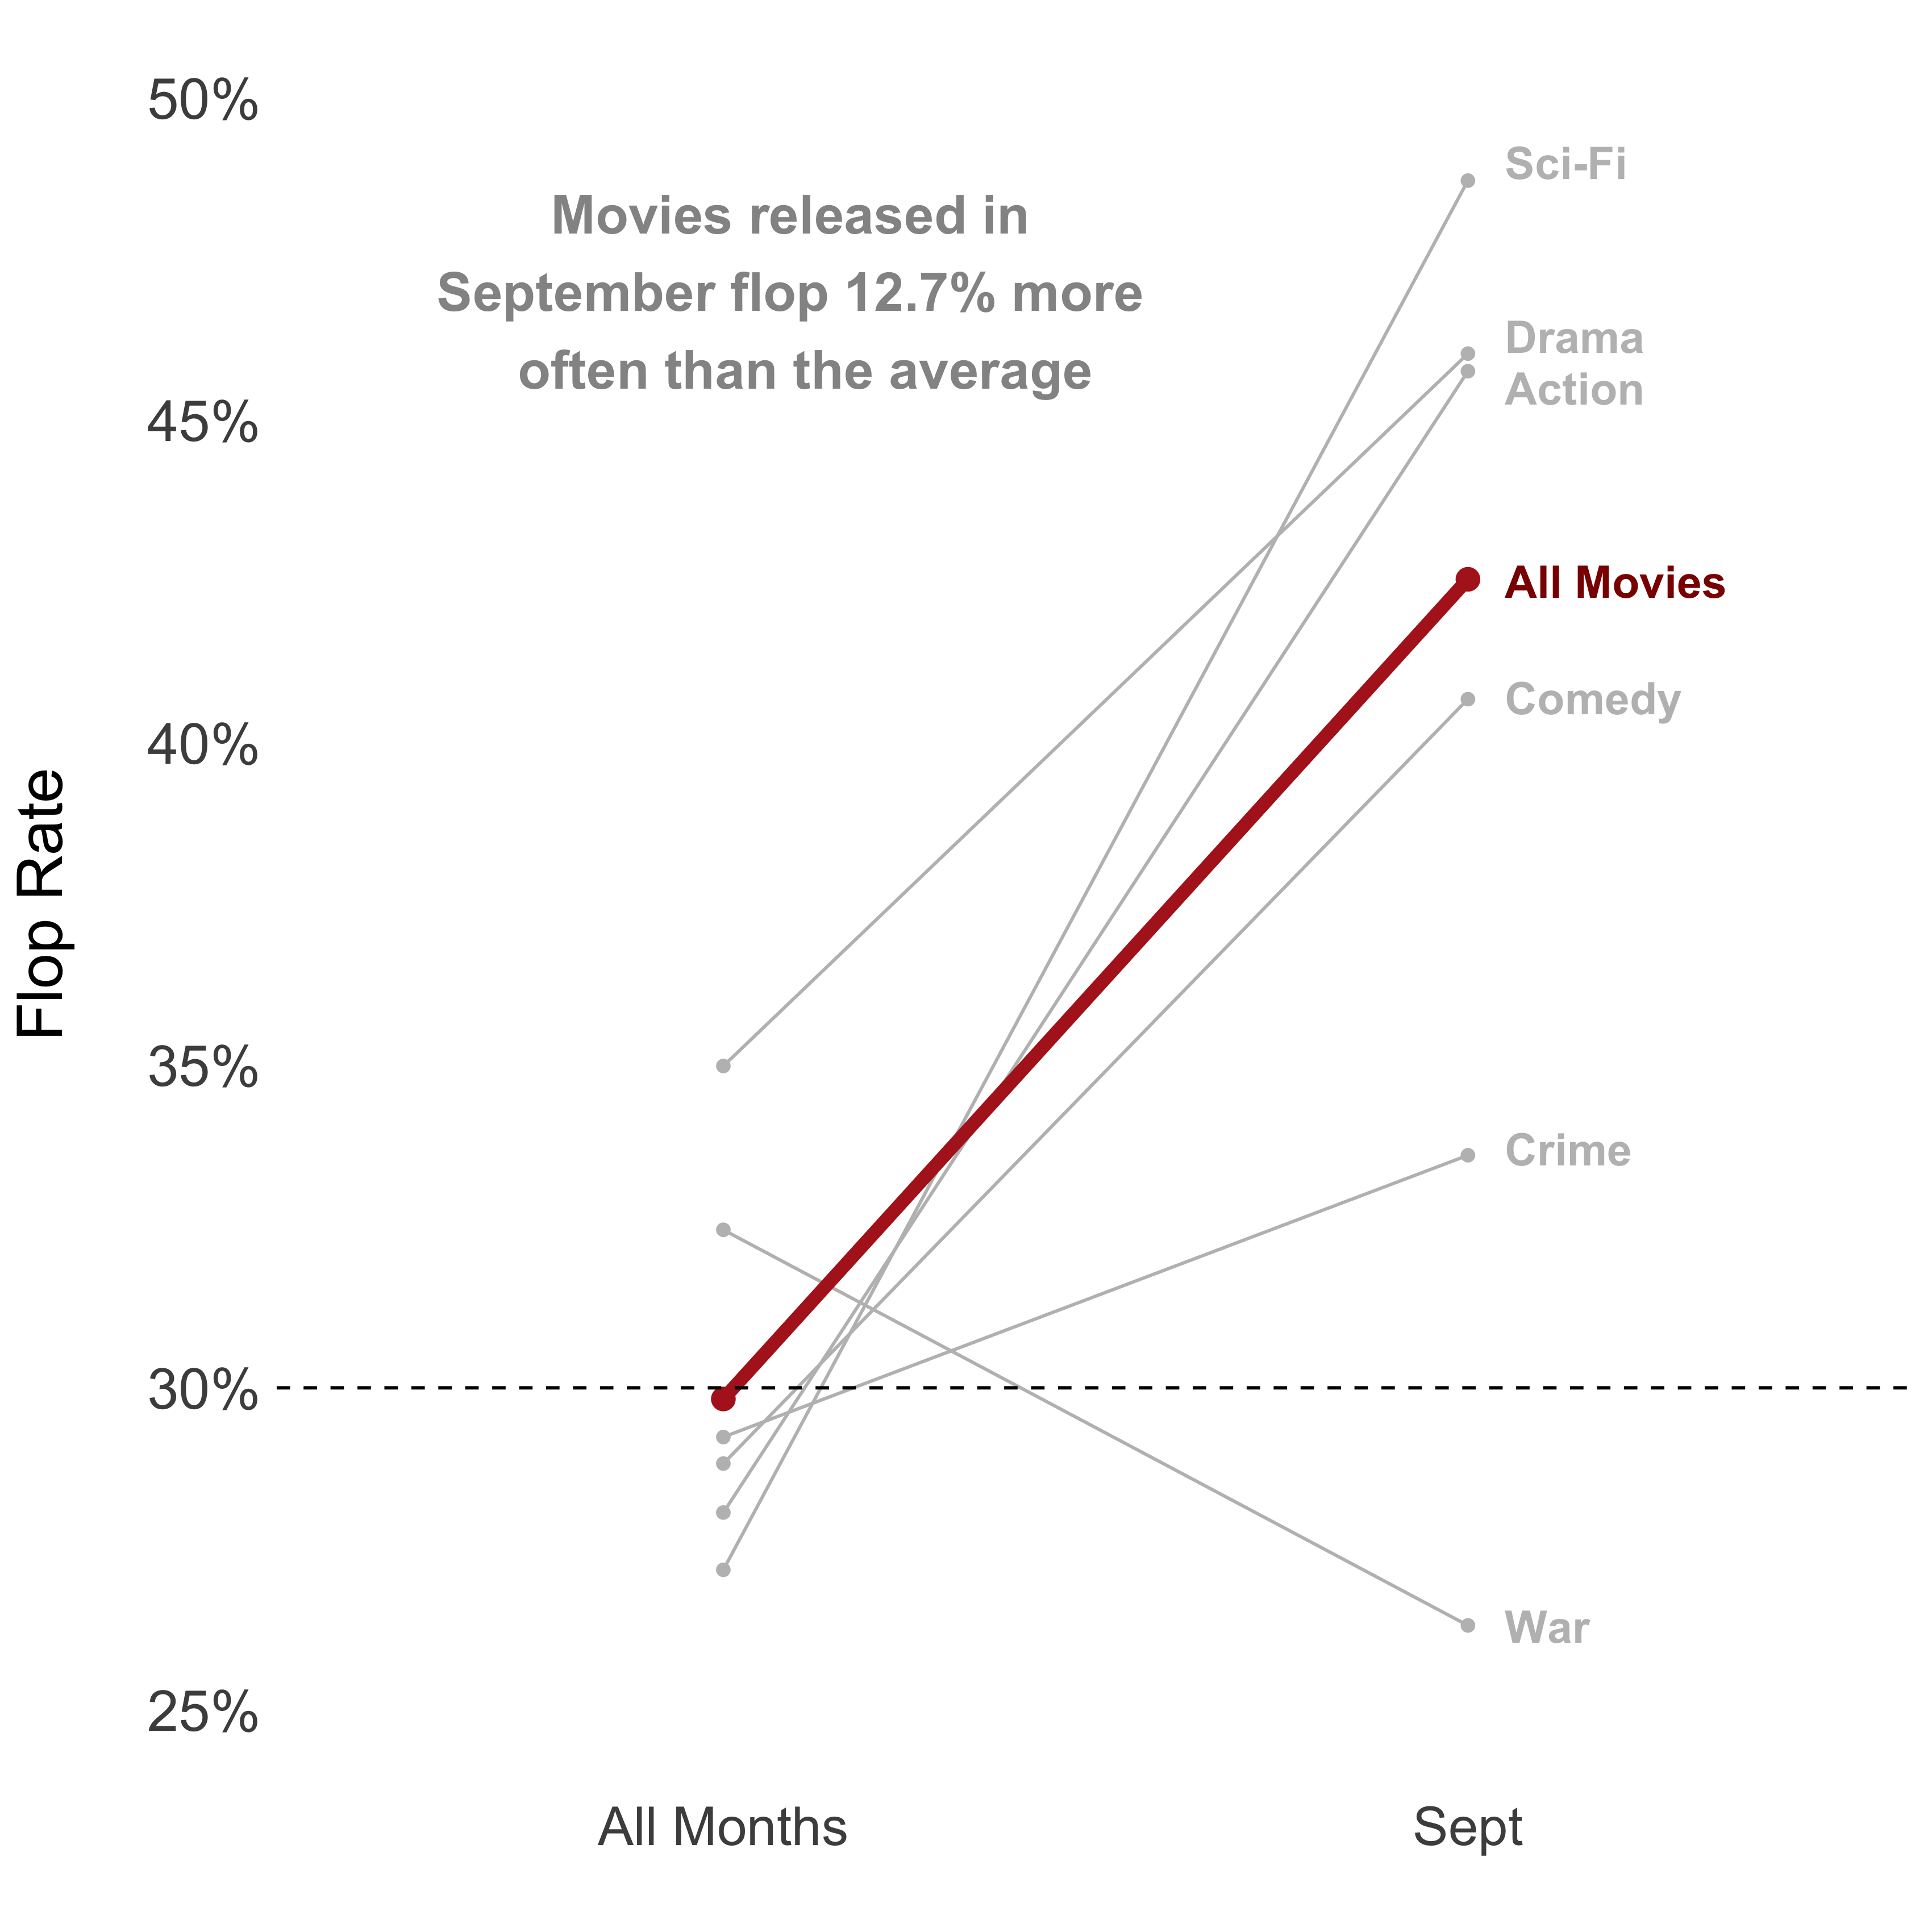

In [34]:
%%R -w 8.5 -h 8.5 --units in -r 400
(
ggplot()
+geom_line(aes(x=Time,y=FR,group = genre),data = importdf, color = 'gray')
+geom_point(aes(x=Time,y=FR),data = importdf, color = 'gray')
+ scale_y_continuous(limits = c(0.25, 0.5), breaks = seq(0.25, 0.5, by = .05), label = percent)
+ scale_x_discrete(limits = c('All Months', 'Sept')) #How could I bring this in?

+geom_line(aes(x=Time,y=FR,group = 1),data = alldf, color = 'firebrick',size = 2)
+geom_point(aes(x=Time,y=FR),data = alldf, color = 'firebrick', size = 3)
+ geom_hline(yintercept = 0.3, linetype = 'dashed')
+ylab('Flop Rate\n')
+xlab('')
+ theme(
        axis.text.y=element_text(size = 18)
        , axis.text.x=element_text(size = 17)
        , axis.title.y=element_text(size = 20)
        , axis.title.x=element_text(size = 20)
        , panel.background=element_blank()
        , panel.grid.major=element_blank()
        , panel.grid.minor=element_blank()
        , axis.ticks = element_blank()
    )
+ annotate("text", x = 1.1, y = 0.47
           , label = "Movies released in \nSeptember flop 12.7% more \n often than the average"
           ,color = 'gray58', fontface = 'bold', size = 6)    

+ annotate("text", x = 2.05, y = 0.425, label = "All Movies",fontface = 'bold', color = 'red4', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.49, label = "Sci-Fi",fontface = 'bold', color = 'gray', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.463, label = "Drama",fontface = 'bold', color = 'gray', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.455, label = "Action",fontface = 'bold', color = 'gray', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.407, label = "Comedy",fontface = 'bold', color = 'gray', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.337, label = "Crime",fontface = 'bold', color = 'gray', size = 5,hjust = 0)
+ annotate("text", x = 2.05, y = 0.263, label = "War",fontface = 'bold', color = 'gray', size = 5,hjust = 0)

)
#ggsave(filename="./finished_figures/fig5.png", width=8.5, height=8.5, units='in')

# More Data Manipulations

In [35]:
movies = pd.read_csv("./movie_dataset_edited/flopTripleByGenre.csv")

In [36]:
movies['release_date'] = pd.to_datetime(movies['release_date']
                                        , errors='coerce')

In [37]:
# Add Release Year Column to Dataset
movies['year'] = movies['release_date'].dt.year

In [38]:
# Add Release Month Column to Dataset
movies['month'] = movies['release_date'].dt.month

In [39]:
# Dictionary to map abbreviate month names to numbers
months = {1: "Jan", 2: "Feb", 3: "Mar"
          , 4: "Apr", 5: "May", 6: "Jun"
          , 7: "Jul", 8: "Aug", 9: "Sep"
          , 10: "Oct", 11: "Nov", 12: "Dec"}

In [40]:
# Converting month numbers to abbreviated month name
movies = movies.replace({'month':months})

In [41]:
# Removing Foreign Movies
movies = movies.loc[~(movies.genre == 'Foreign')]

In [42]:
# Create separate dataframe of only flops
flop = movies.loc[(movies.profit < 0)]

In [43]:
# Create separate dataframe of only successful movies
success = movies.loc[(movies.profit > 0)]

# Figure 6 - Percentage of Flops for Each Genre For each month

In [44]:
# Count the number of movies for each genre in each month for flops
flopTime = flop.groupby(['month', 'genre']).agg({'genre':'count'})
flopTime.columns = ['flopCount']
flopTime = flopTime.reset_index()
# Count the number of movies for each genre in each month for successful movies
successTime = success.groupby(['month', 'genre']).agg({'genre':'count'})
successTime.columns = ['successCount']
successTime = successTime.reset_index()

In [45]:
# Merge Dataframes and calculate the percentage of flops
merge = pd.merge(successTime, flopTime, on=['genre', 'month'], how='inner')
merge['percentFlop'] = merge.flopCount/(merge.flopCount+merge.successCount)

In [46]:
# Aggregate mean values accross all variables for each genre for flops
flop1 = (flop.groupby('genre')
         .agg({'genre':'count','runtime':'mean','rating':'mean','budget':'mean'}))
flop1.columns = ['flopCount', 'runtime', 'rating', 'budget']
flop1 = flop1.reset_index()

In [47]:
# Aggregate mean values accross all variables for each genre for successful movies
success1 = (success.groupby('genre')
            .agg({'genre':'count','runtime':'mean','rating':'mean','budget':'mean'}))
success1.columns = ['successCount', 'runtime', 'rating', 'budget']
success1 = success1.reset_index()

In [48]:
# Merge aggregated datasets and calculate flop percentage
merge2 = pd.merge(flop1, success1, on = 'genre', how = 'inner')
merge2['percentFlop'] = merge2.flopCount/(merge2.flopCount+merge2.successCount)

In [49]:
# Find the low risk genres to avoid for future
lowrisk = merge2[['genre','percentFlop']].nsmallest(11, 'percentFlop')

In [50]:
# Create list of all genre titles that are low risk
lowRiskList = []
for genre in lowrisk['genre']:
    lowRiskList.append(genre)

In [51]:
# Create Dataframes for high risk genres that are above and below the overall average flop rate
highRisk = merge.loc[~(merge.genre.isin(lowRiskList))]
highRisk2 = highRisk.loc[(highRisk.percentFlop > .3) | (highRisk.percentFlop < .3)]
highRisk2.loc[(highRisk2.percentFlop > .3), 'AboveBelow'] = 'Above'
highRisk2.loc[(highRisk2.percentFlop < .3), 'AboveBelow'] = 'Below'

/Users/nickparker/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/nickparker/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
# Group by month and find the mean flop rate
highRiskAvg = highRisk2.groupby('month').agg({'percentFlop':'mean'}).reset_index()

In [53]:
# Group by genre and find the minimun flop rate and then merge with other dataframe to keep month
riskMin = highRisk2.groupby('genre').agg({'percentFlop':'min'})
riskMin = riskMin.loc[(riskMin.percentFlop < .3)]
riskMin = pd.merge(riskMin, highRisk2, on = ['genre', 'percentFlop'], how = 'left')
# Group by genre and find the maximum flop rate and then merge with other dataframe to keep month
riskMax = highRisk2.groupby('genre').agg({'percentFlop':'max'})
riskMax = riskMax.loc[(riskMax.percentFlop >= 0.3)]
riskMax = pd.merge(riskMax, highRisk, on = ['genre', 'percentFlop'], how = 'left')

In [54]:
# Prepare to be passed to R
riskMinR = fixDFcolsForR(riskMin.copy())
riskMaxR = fixDFcolsForR(riskMax.copy())
highRiskAvgR = fixDFcolsForR(highRiskAvg.copy())

In [55]:
# Pass through R
%R -i riskMinR
%R -i riskMaxR
%R -i highRiskAvgR

In [56]:
# Pass through R
risk2R = fixDFcolsForR(highRisk2.copy())
%R -i risk2R

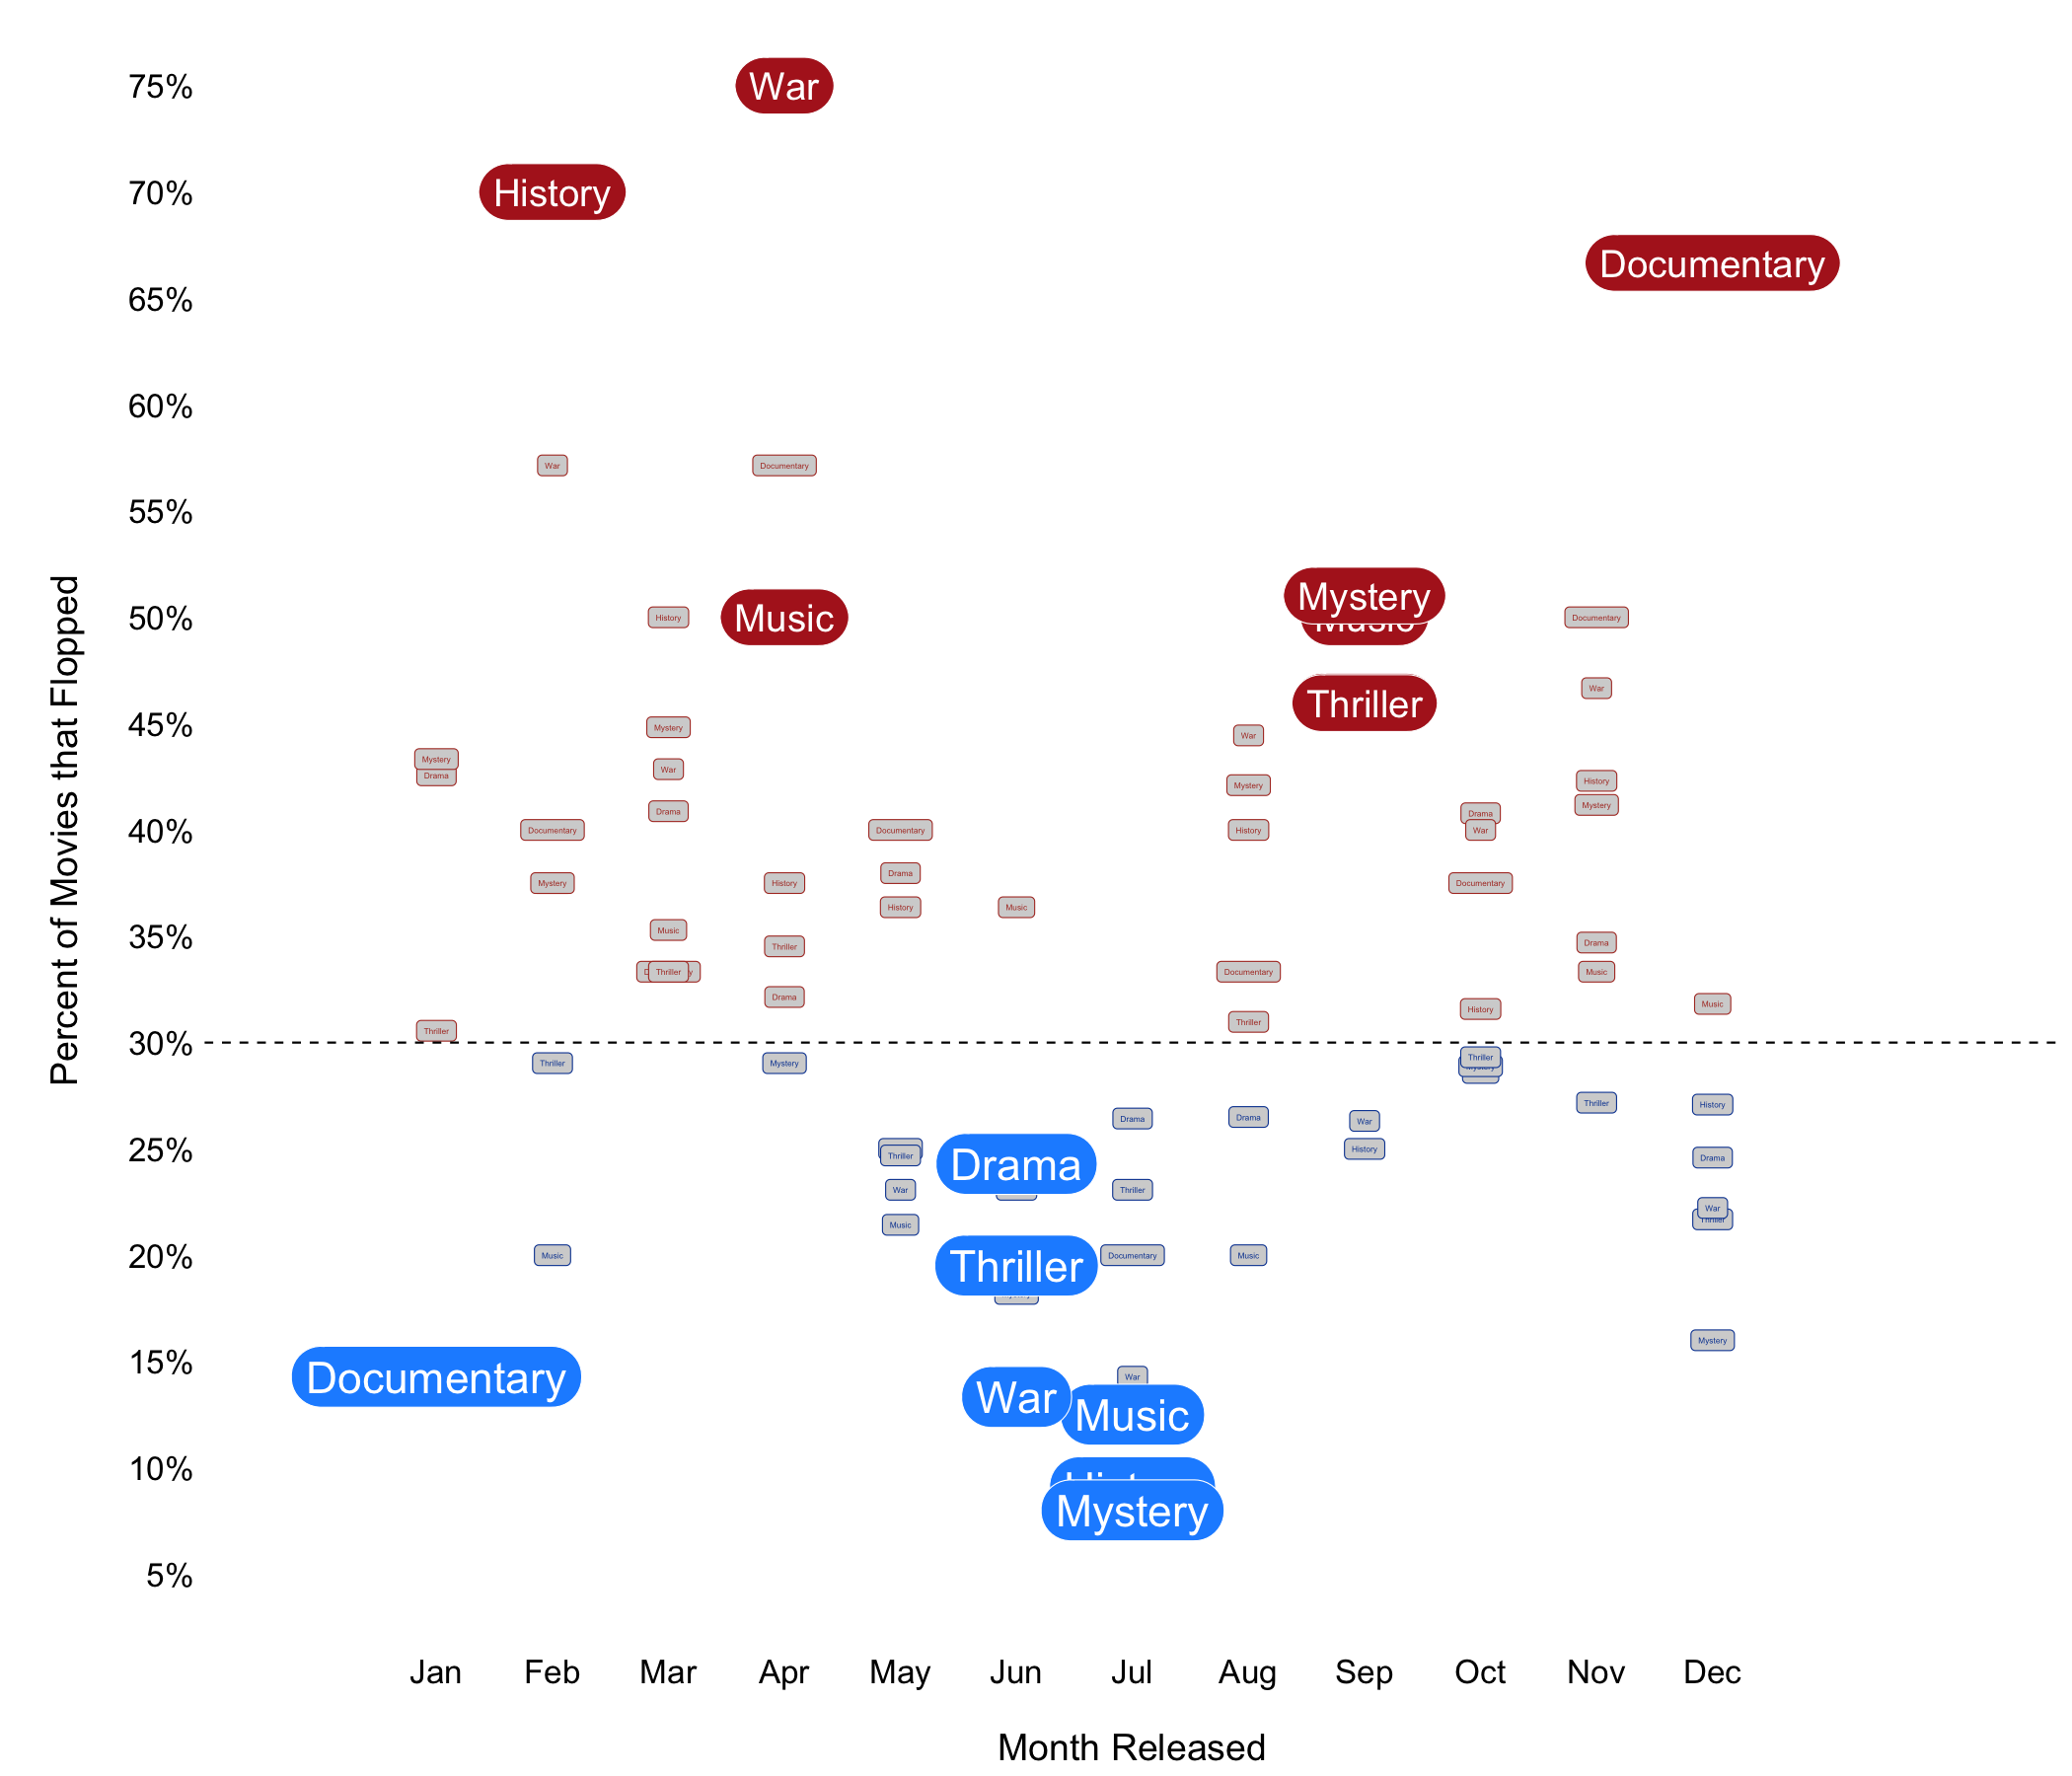

In [57]:
%%R -w 14 -h 12 --units in -r 150
ggplot() +
    geom_label(aes(x = factor(month
                              , levels=c('Jan','Feb','Mar'
                                         ,'Apr','May','Jun'
                                         ,'Jul','Aug','Sep'
                                         ,'Oct','Nov','Dec'))
                   , y = percentFlop, label = genre, color = AboveBelow)
               , fill = 'lightgray'
               ,data = risk2R, size = 1.4
               , show.legend = FALSE) +
    scale_color_manual(values = c('#B03A2E', '#0D47A1')) +
    geom_label(aes(x = month, y = percentFlop, label = genre)
               , size = 7.5, fill = 'dodgerblue'
               , data = riskMinR
               , color = 'white'
               , show.legend = FALSE
              , label.padding = unit(0.5,"lines")
              , label.r = unit(1, "lines")) +
    geom_label(aes(x = month, y = percentFlop, label = genre)
               , fill = 'firebrick'#B03A2E
               , data = riskMaxR
               , size = 6.5
               , show.legend = FALSE
              , color = 'white'
              , label.padding = unit(0.5,"lines")
              , label.r = unit(1, "lines")) +
    scale_y_continuous(label = percent
                       , breaks = seq(0.05,.75,.05)
                       ,limits = c(0.05,.75)) +
    ylab('\nPercent of Movies that Flopped\n') + 
    geom_hline(aes(yintercept = 0.3), linetype = 'dashed', color = 'black') +
    theme(panel.background = element_blank()
          , axis.ticks = element_blank()
          , axis.text = element_text(color = 'black', size = 16)
         , axis.title = element_text(size = 18))+
    xlab('\nMonth Released') +
    expand_limits(x = c(-1,15), y = 0.)
#ggsave(filename="GenreMonth.png", width=14, height=12, units='in')

# Figure 7 - Zoom in to the important aspects of visual

In [58]:
riskMin.percentFlop.mean()

0.14430848163234627

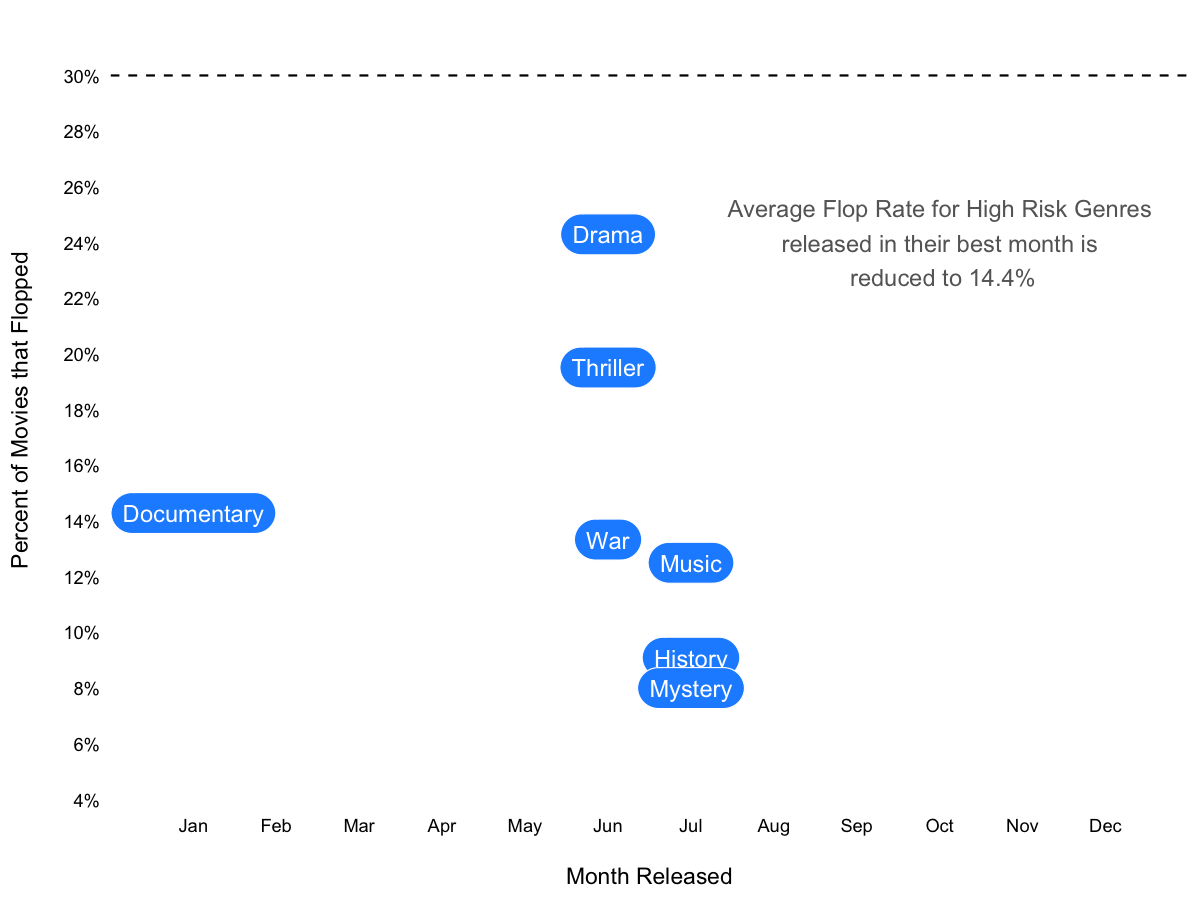

In [59]:
%%R -w 8 -h 6 --units in -r 150
ggplot() +
    geom_label(aes(x = month, y = percentFlop, label = genre)
               , size = 4, fill = 'dodgerblue'
               , data = riskMinR, color = 'white'
               , show.legend = FALSE
              , label.padding = unit(0.4,"lines")
              , label.r = unit(0.7, "lines")) +
    scale_y_continuous(label = percent
                       , breaks = seq(0.04,.31,.02)
                       ,limits = c(0.05,.31)) +
    ylab('Percent of Movies that Flopped\n') + 
    geom_hline(aes(yintercept = 0.3)
               , linetype = 'dashed', color = 'black') +
    theme(panel.background = element_blank()
          , axis.ticks = element_blank()
          , axis.text = element_text(color = 'black'))+
    xlab('\nMonth Released') +
    scale_x_discrete(limits = c('Jan','Feb','Mar'
                                ,'Apr','May','Jun'
                                ,'Jul','Aug','Sep'
                                ,'Oct','Nov','Dec')) +
    geom_text(aes(label = 'Average Flop Rate for High Risk Genres\nreleased in their best month is\n reduced to 14.4%'
                  , x = 'Oct', y = 0.24), color = 'grey40', size = 4) +
    expand_limits(x = c(0, 13))
#ggsave(filename="ConclusionImg.png", width=8, height=6, units='in')

# Figure 4- Identify High Risk Genres

In [60]:
# Create column to declare if genre is high risk or not for coloring purposes
merge2.loc[(merge2.percentFlop >= 0.3), 'highrisk'] = 'high'
merge2.loc[(merge2.highrisk.isna()), 'highrisk'] = 'low'
low = merge2.loc[(merge2.highrisk == 'low')]
high = merge2.loc[(merge2.highrisk == 'high')]

In [61]:
# Prepare for R
mergeR = fixDFcolsForR(merge2.copy())
lowR = fixDFcolsForR(low.copy())
highR = fixDFcolsForR(high.copy())

In [62]:
# Pass through R
%R -i mergeR
%R -i lowR
%R -i highR

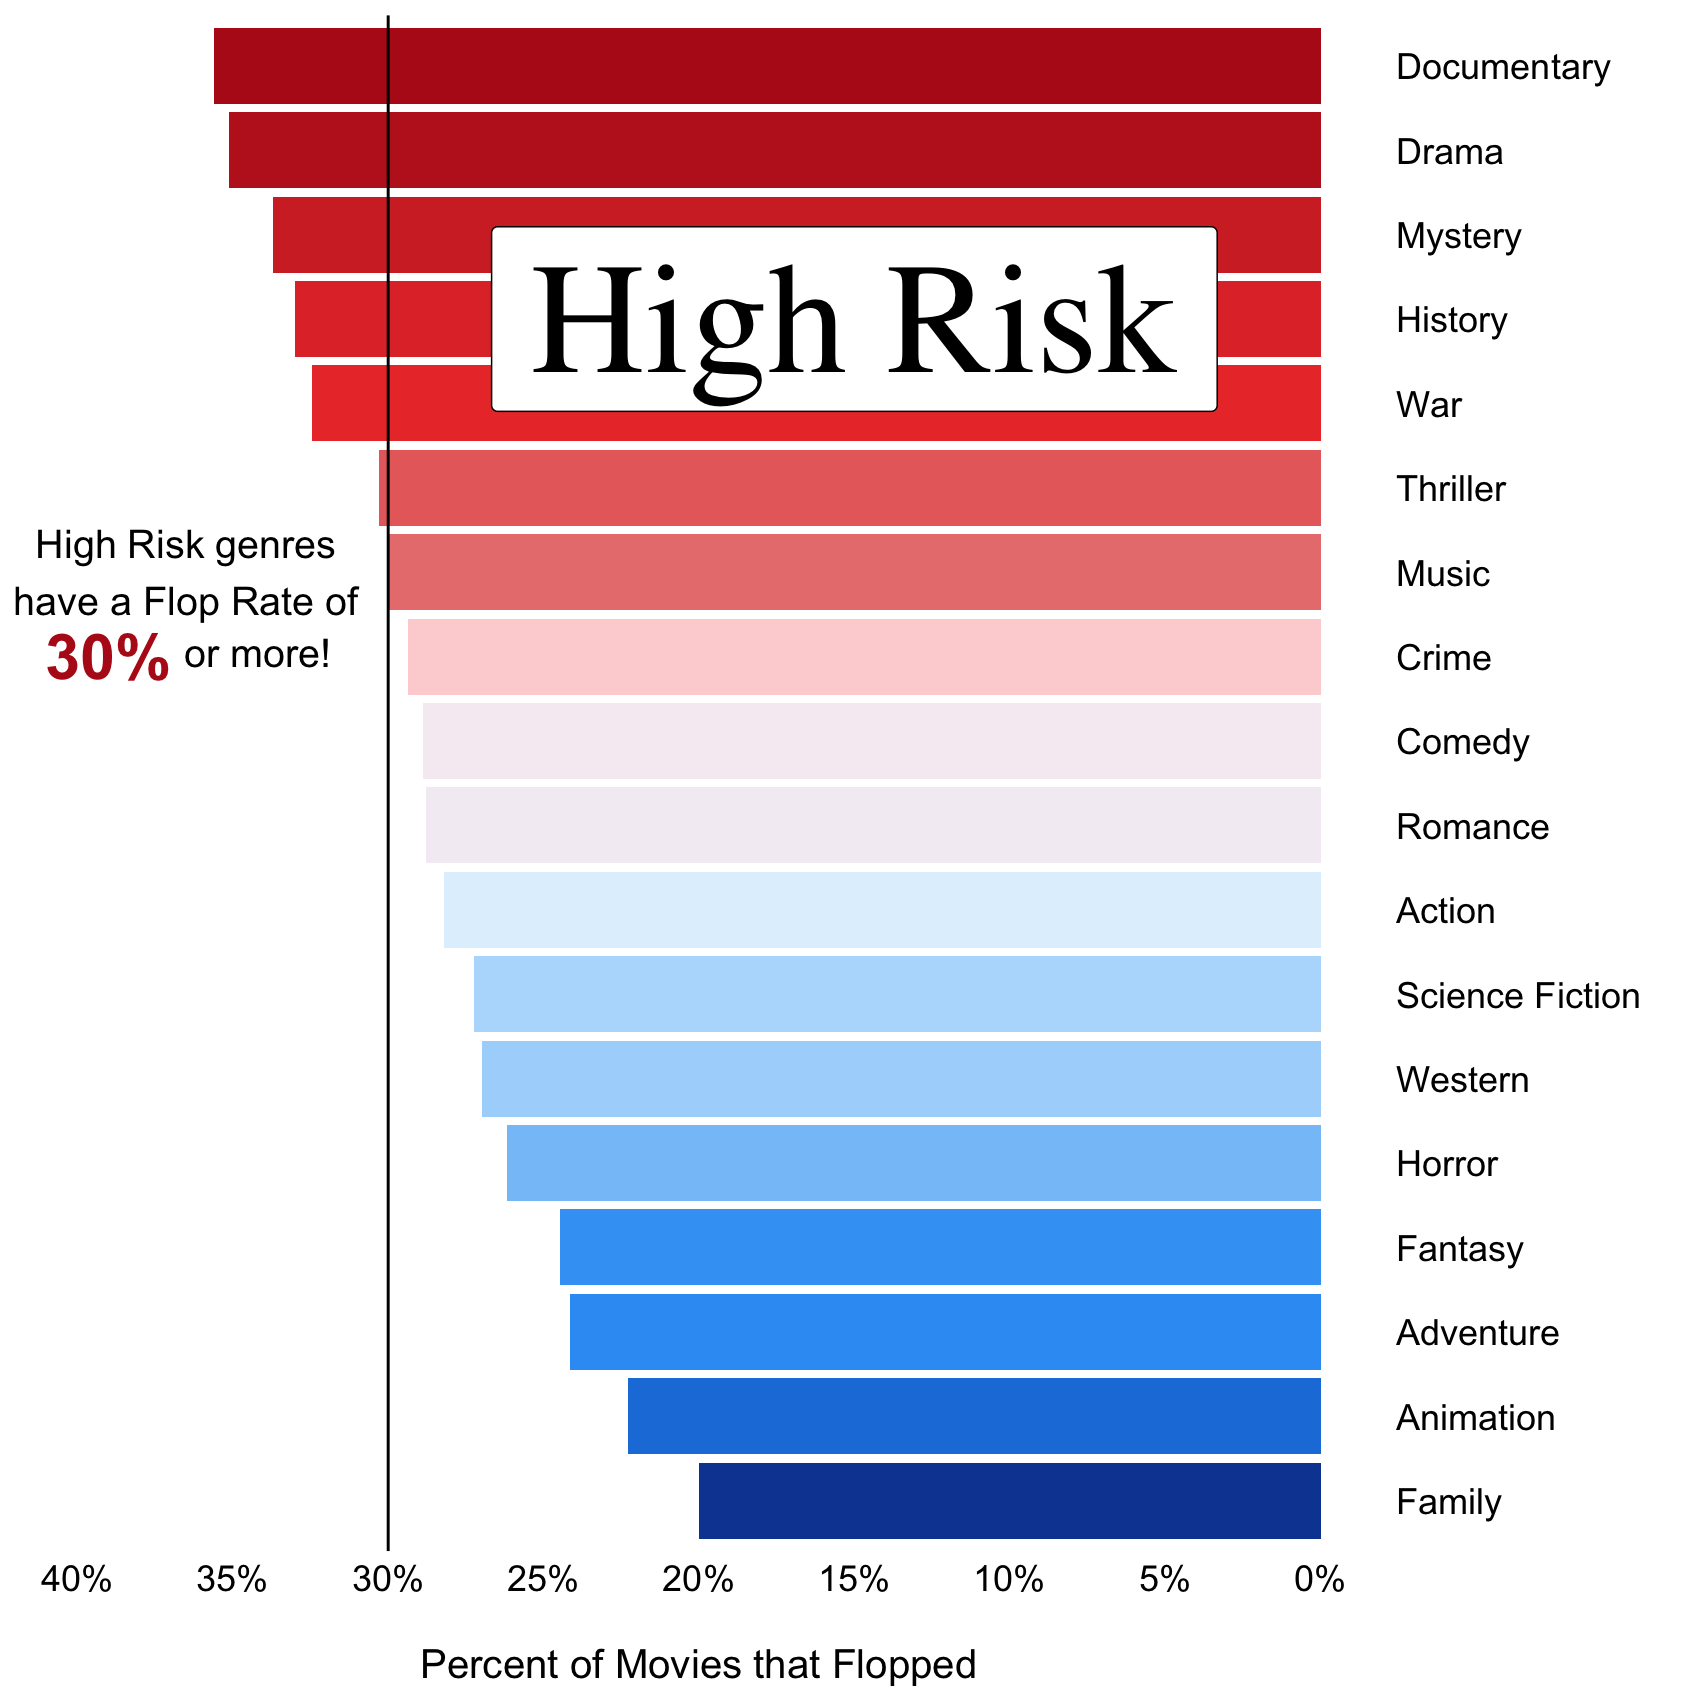

In [63]:
%%R -w 8.5 -h 8.5 --units in -r 200
ggplot() +
    geom_bar(aes(x = reorder(genre, percentFlop)
                 , weight = percentFlop, fill = percentFlop)
             , data = mergeR
             , show.legend = FALSE) +
    scale_fill_gradientn(colors = c('#0D47A1', '#1565C0', '#1976D2'
                                    , '#1E88E5', '#2196F3', '#42A5F5'
                                    , '#64B5F6', '#90CAF9', '#BBDEFB'
                                    , '#E3F2FD', '#FFEBEE','#E57373'
                                    , '#EF5350', '#F44336', '#E53935'
                                    , '#D32F2F', '#C62828', '#B71C1C')) +
    geom_hline(aes(yintercept = 0.3), color = 'black') +
    coord_flip() +
    xlab('') +
    ylab('\nPercent of Movies that Flopped') + 
    scale_y_continuous(trans = "reverse"
                       , breaks = seq(0.4,0,-0.05)
                       , limits=c(0.4,0.0), label = percent) +
    scale_x_discrete(position='top') +
    theme(panel.background = element_blank()
          , axis.ticks = element_blank()
          , axis.text = element_text(color = 'black', size = 13)
         , axis.title = element_text(size = 14.5)) +
    geom_label(aes(label = 'High Risk', y = 0.15, x = 'History')
               , size = 20
               , color = 'black'
               ,label.padding = unit(1, "lines")
               , family = "Times") +
    geom_text(aes(label = 'High Risk genres\nhave a Flop Rate of'
                  , x = 'Music'
                  ,y = 0.365)
             , size = 5) +
    geom_text(aes(label = '30%', x = 'Music', y = 0.35)
              , nudge_x = -0.99
              , nudge_y = -0.04
              , size = 8
              , fontface = 'bold'
              , color = '#B71C1C') +
    geom_text(aes(label = 'or more!', x = 'Crime', y = 0.35)
              , nudge_x = 0.05, nudge_y = 0.008, size = 5)
#ggsave(filename="HighRisk.png", width=8.5, height=8.5, units='in')

# Figure 3 - Average Rating Vs. Year for both flops and successful movies

In [64]:
# Aggregate on average rating by year
flopRatings = flop.groupby(['year']).agg({'rating':'mean'}).reset_index()
successRatings = success.groupby(['year']).agg({'rating':'mean'}).reset_index()

In [65]:
# Only focus on movies from 1985 and on
flopRatings = flopRatings.loc[(flopRatings.year >= 1985)]
successRatings = successRatings.loc[(successRatings.year >= 1985)]

In [66]:
# Calculate the average difference of rating between flop and successful movie
avgDiff = pd.merge(successRatings, flopRatings, on = 'year', how = 'inner')
avgDiff.columns = ['year','successRating', 'flopRating']
avgDiff['Diff'] = avgDiff.successRating - avgDiff.flopRating
avgDiff.Diff.mean()

0.17031304929550764

In [67]:
# Create list of movies that were flops to show in plot
linePoints = (movies.groupby('title')
              .agg({'profit':'min','year':'min', 'rating':'min'})
              .reset_index())
linePoints = (linePoints.loc[(linePoints.year >= 1985)]
              .nsmallest(10,'profit'))

In [68]:
# Get rid of movies nobody will know
linePoints = linePoints.loc[(linePoints.title != 'Cutthroat Island')]
linePoints = linePoints.loc[(linePoints.title != 'Mars Needs Moms')]

In [69]:
# Prepare for R
linePointsR = fixDFcolsForR(linePoints.copy())
flopRatingsR = fixDFcolsForR(flopRatings.copy())
successRatingsR = fixDFcolsForR(successRatings.copy())

In [70]:
# Pass to R
%R -i flopRatingsR
%R -i successRatingsR
%R -i linePointsR

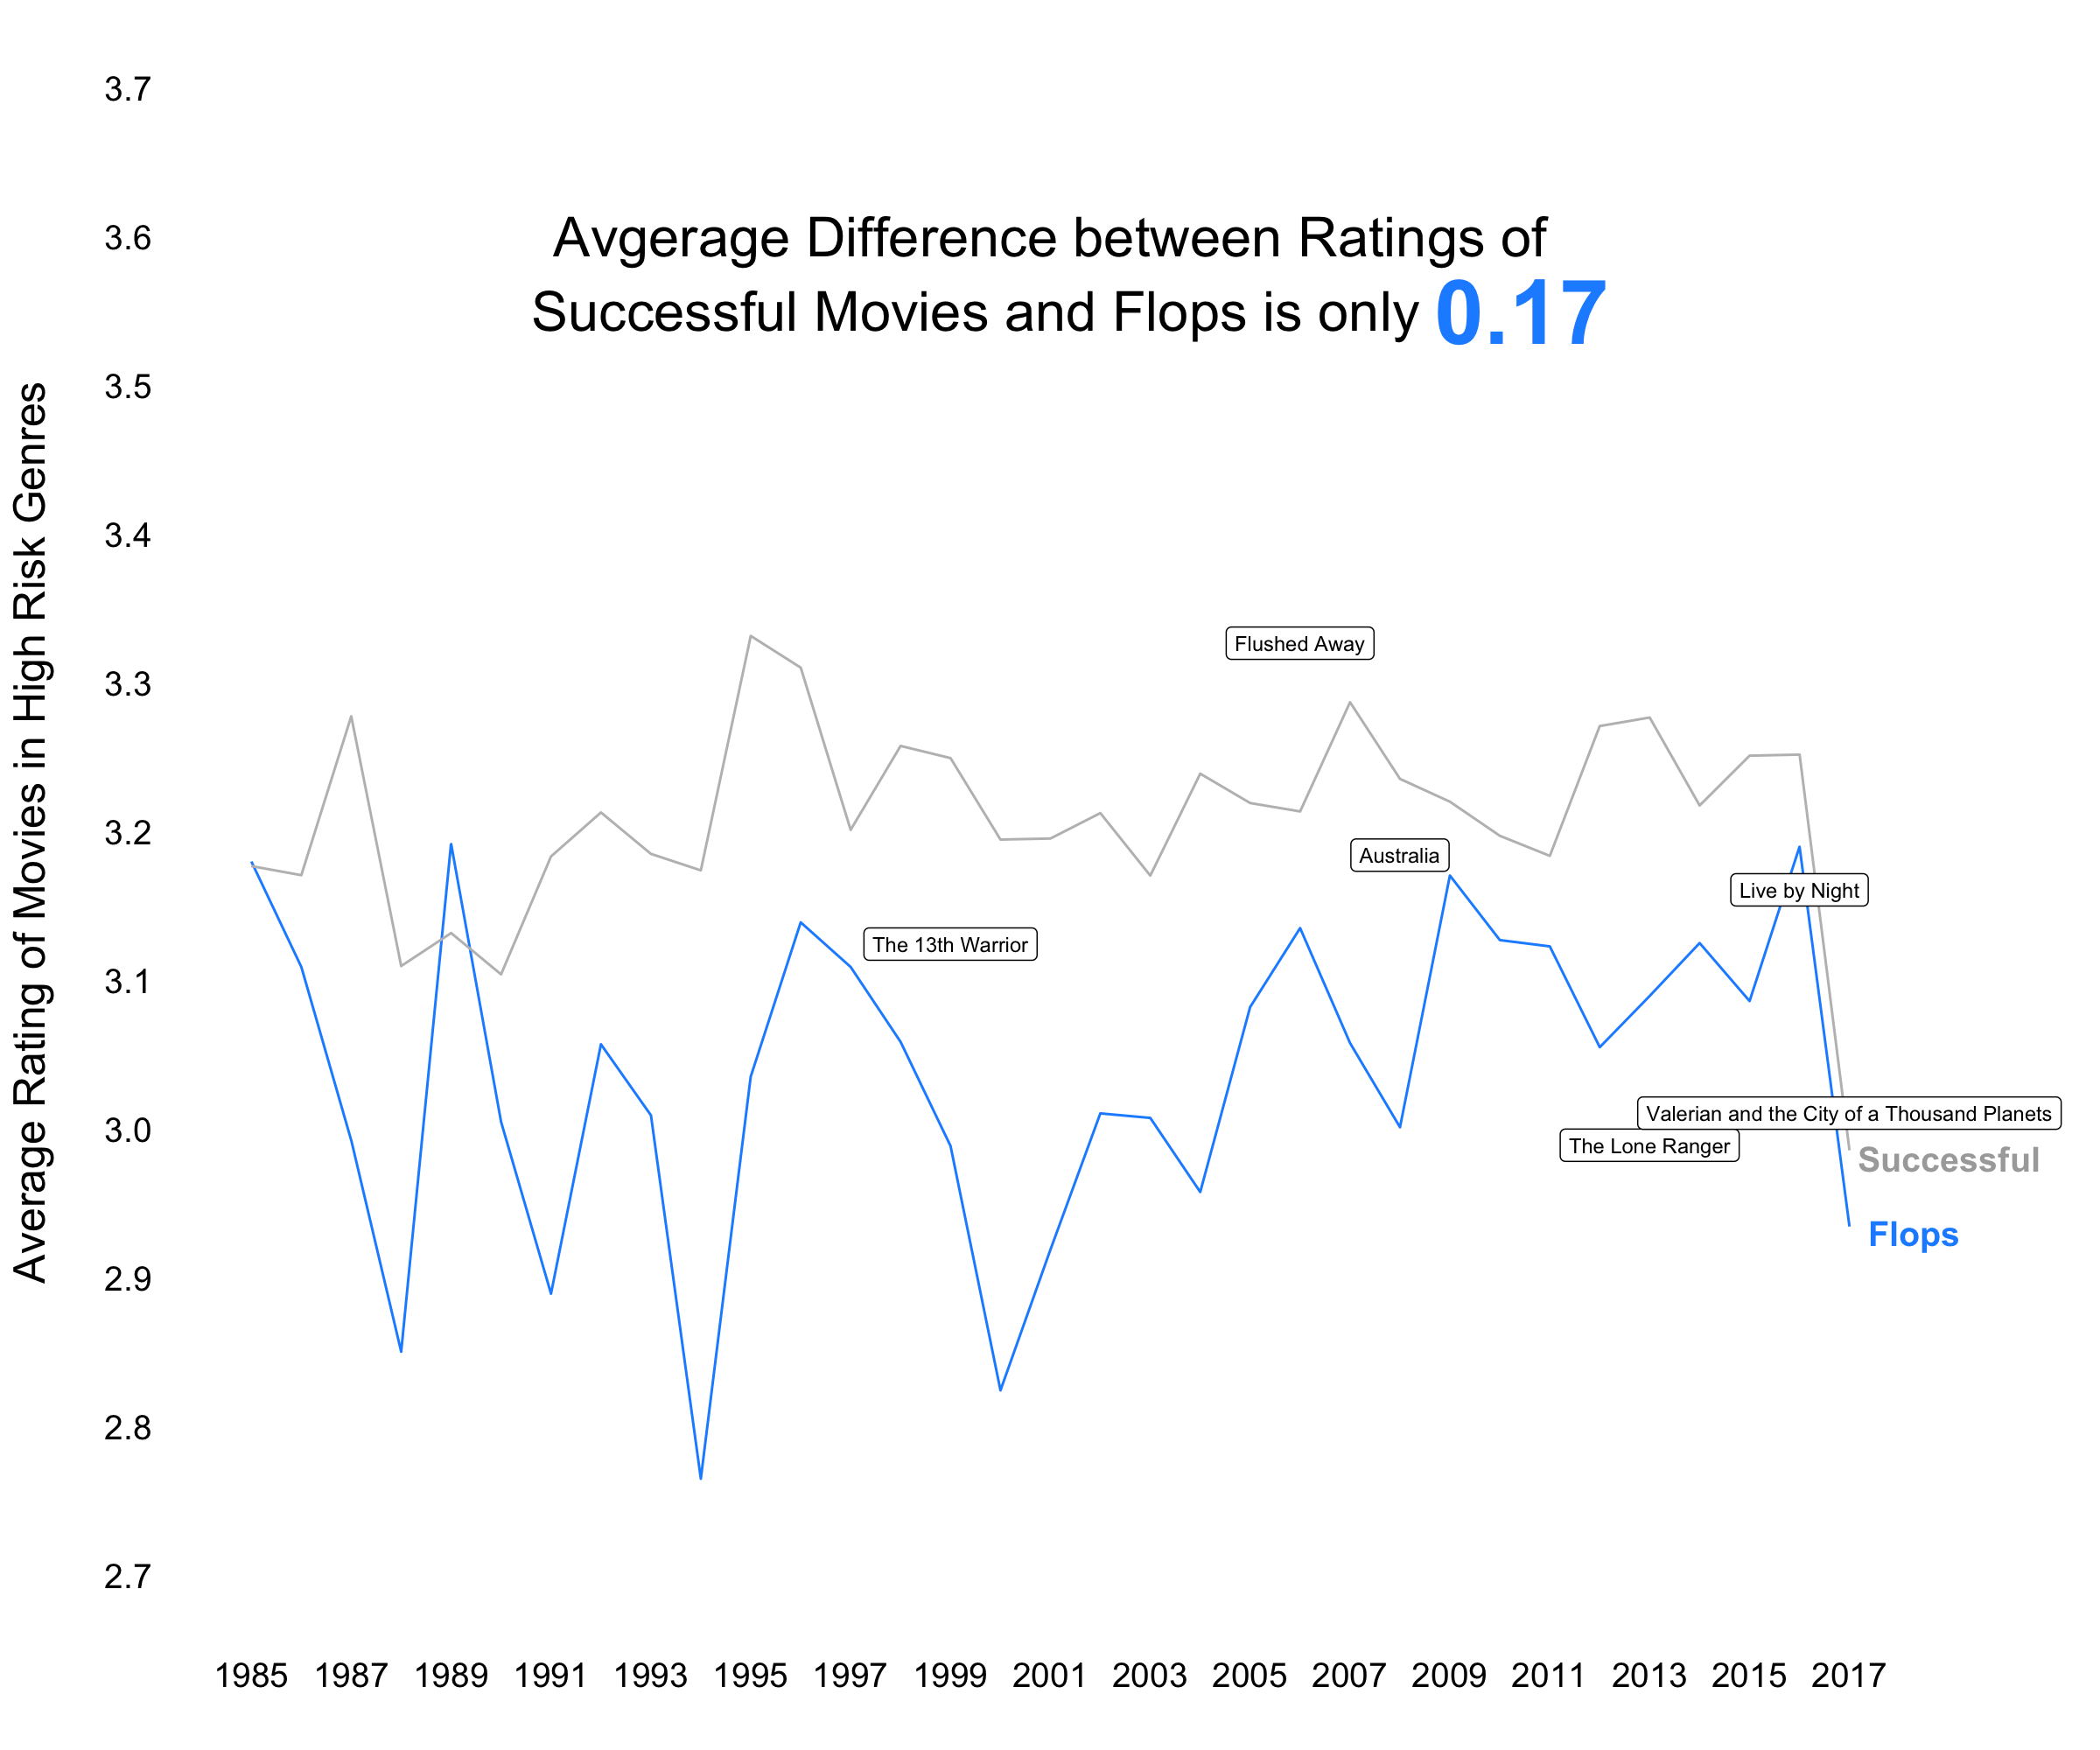

In [71]:
%%R -w 12 -h 10 --units in -r 200
ggplot() +
    geom_line(aes(x = year, y = rating, group = 1)
              , data = flopRatingsR
              , color = 'dodgerblue') + 
    geom_text(aes(x = 2017, y = 2.93, label = 'Flops')
              , color = 'dodgerblue'
              , nudge_x = 1.3
              , fontface = 'bold'
             , size = 5) +
    geom_line(aes(x = year, y = rating, group = 1)
              , data = successRatingsR
              , color = 'gray') +
    geom_text(aes(x = 2017, y = 2.98, label = 'Successful')
              , nudge_x = 2
              , color = 'darkgray'
              , fontface = 'bold'
             , size = 5) +
    scale_x_continuous(breaks = seq(1985,2017.5,2)
                       , limits=c(1985,2020)) + 
    scale_y_continuous(breaks = seq(2.7, 3.7, .1)
                       , limits=c(2.7,3.7)) +
    geom_label(aes(label = title, x = year, y = rating)
               , data = linePointsR, size = 3) +
    theme(panel.background = element_blank()
          , axis.ticks = element_blank()
          , axis.text = element_text(color = 'black', size = 14)
         , axis.title = element_text(size = 18)) + 
    xlab('') + 
    ylab('Average Rating of Movies in High Risk Genres\n') + 
    geom_text(aes(label = 'Avgerage Difference between Ratings of',
                 x = 2001, y = 3.6), size = 8) +
    geom_text(aes(label = 'Successful Movies and Flops is only', x = 2001, y = 3.55)
              , nudge_x = -1.5, size = 8) +
    geom_text(aes(label = '0.17', x = 2001, y = 3.55)
              , color = 'dodgerblue'
              , size = 13
              , fontface = 'bold'
              , nudge_x = 9.45)
#ggsave(filename="RatingYear.png", width=12, height=10, units='in')